In [511]:
import requests
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pandas_ta as ta
import mplfinance as mpf

import modules.cryptodownloader as cd

## Prepare dataset

In [512]:
dfa = cd.downloadIntraday('BTC', 'USD', 1622110000, 1622512350)

Reusing cached results
Reusing cached results
Reusing cached results
Reusing cached results
Download complete. count=8000


In [513]:
dfb = cd.downloadIntraday('BTC', 'USD', 1622572350, 1623172687)

Reusing cached results
Reusing cached results
Reusing cached results
Reusing cached results
Reusing cached results
Reusing cached results
Download complete. count=10080


In [514]:
dfc = cd.downloadIntraday('BTC', 'USD', 1623223687, 1623434504)

Reusing cached results
Reusing cached results
Download complete. count=4000


In [515]:
print(dfa)
print(dfb)
print(dfc)

df = pd.DataFrame(dfa)
df = df.append(dfb)
df = df.append(dfc)
print(len(df))
# df[df.duplicated()]

                         open      high       low     close  volume
date                                                               
2021-05-26 12:32:00  40204.31  40206.15  40154.19  40155.06  16.220
2021-05-26 12:33:00  40155.06  40176.97  40132.05  40150.54  42.940
2021-05-26 12:34:00  40150.54  40157.61  40114.13  40127.63  47.940
2021-05-26 12:35:00  40127.63  40128.55  40069.08  40081.49  22.790
2021-05-26 12:36:00  40081.49  40104.75  40073.63  40104.75  40.720
...                       ...       ...       ...       ...     ...
2021-06-01 01:47:00  37306.01  37306.01  37290.54  37295.28  10.360
2021-06-01 01:48:00  37295.28  37333.51  37295.28  37315.14  27.720
2021-06-01 01:49:00  37315.14  37330.90  37311.10  37330.87  21.700
2021-06-01 01:50:00  37330.87  37367.66  37330.87  37356.29   6.169
2021-06-01 01:51:00  37356.29  37366.99  37321.30  37328.20   7.304

[8000 rows x 5 columns]
                         open      high       low     close  volume
date                   

### Calculate technical indicators

In [516]:
df3 = df.copy()
# df3 = df3[1000:1600]

df3['rsi'] = df3.ta.rsi()
df3['atr'] = df3.ta.atr(length=20)
df3['linreg_fast'] = df3.ta.linreg(length=20)
df3['linreg_normal'] = df3.ta.linreg(length=50)
df3['linreg_slow'] = df3.ta.linreg(length=200)
df3['sma_fast'] = df3.ta.sma(length=20)
df3['sma_slow'] = df3.ta.sma(length=200)
df3['ema_fast'] = df3.ta.ema(length=20)
df3['ema_slow'] = df3.ta.ema(length=200)
df3['vwap'] = df3.ta.vwap(length=20)

st = df3.ta.supertrend()
df3['supertrend'] = st['SUPERT_7_3.0']
df3['supertrend_l'] = st['SUPERTl_7_3.0']
#0-buy; 1-sell
df3[['supertrend_signal']] = df3[['supertrend_l']].where(df3[['supertrend_l']].isnull(), 1).fillna(0).astype(int)
df3 = df3.drop(columns=['supertrend_l'])

# df3.tail()

### Feature engineering

In [517]:
df4 = df3.copy()

df4['close_ratio'] = df4['close'].pct_change()
df4['low_ratio'] = df4['low'].pct_change()
df4['high_ratio'] = df4['high'].pct_change()
df4['volume_ratio'] = df4['volume'].pct_change()
df4['vwap_ratio'] = df4['vwap'].pct_change()
df4['vwap_close_diff'] = df4['vwap'] - df4['close']
df4['co_ratio'] = (df4['close'] - df4['open']) /df4['open']
df4['oc_diff'] = (df4['open'] - df4['close'])
df4['hl_diff'] = (df4['high'] - df4['low'])
df4['dir'] = (df4['close'].shift(-1) - df4['close'])
df4['sma_slow_close_diff'] = df4['sma_slow'] - df4['close']
df4['sma_fast_close_diff'] = df4['sma_fast'] - df4['close']

df4['ema_fast_ratio'] = df4['ema_fast'].pct_change()
df4['ema_slow_ratio'] = df4['ema_slow'].pct_change()

print(df4.columns)

Index(['open', 'high', 'low', 'close', 'volume', 'rsi', 'atr', 'linreg_fast',
       'linreg_normal', 'linreg_slow', 'sma_fast', 'sma_slow', 'ema_fast',
       'ema_slow', 'vwap', 'supertrend', 'supertrend_signal', 'close_ratio',
       'low_ratio', 'high_ratio', 'volume_ratio', 'vwap_ratio',
       'vwap_close_diff', 'co_ratio', 'oc_diff', 'hl_diff', 'dir',
       'sma_slow_close_diff', 'sma_fast_close_diff', 'ema_fast_ratio',
       'ema_slow_ratio'],
      dtype='object')


In [518]:
# trans = PolynomialFeatures(degree=3)
# data = trans.fit_transform(data)

### Calculate true classes

In [1254]:
df5 = df4.copy()

#TODO: this is too simple

#nothing
df5['signal'] = 0

# df5['l'] = 3
# df5['h'] = 2

# df5['close_prev'] = df5['close'].shift(periods=40)
df5['close_next'] = df5['close'].shift(periods=-120)

# print(df5[['close_prev','close','close_next']])

#buy
df5.loc[df5['close_next'] > df5['close']*1.03, 'signal'] = 1
# df5.loc[df5['close']*1.05 < df5['close'].shift(-300), 'signal'] = 1

#sell
# df5.loc[df5['close_next'] < df5['close']*0.98, 'signal'] = 2
# df5.loc[df5['close']*0.98 > df5['close'].shift(+30), 'signal'] = 2


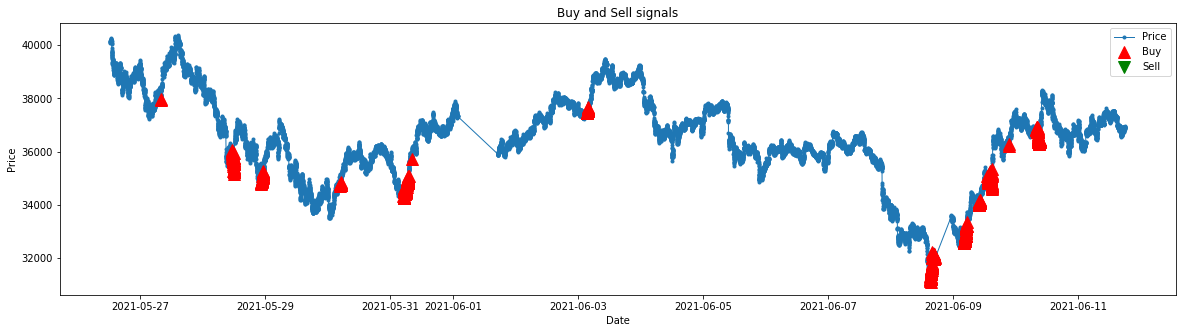

In [1255]:
dfg = df5.copy()
# dfg = dfg[2000:5000]
fig = plt.figure(figsize=(20, 5))
buys = dfg.loc[df5["signal"] == 1]
sells = dfg.loc[df5["signal"] == 2]
plt.plot(dfg.index, dfg['close'], lw=1., marker='.', label='Price')
plt.plot(buys.index, dfg.loc[buys.index]['close'], '^', markersize=12, color='red', lw=2., label='Buy')
plt.plot(sells.index, dfg.loc[sells.index]['close'], 'v', markersize=12, color='green', lw=2., label='Sell')
# plt.vlines(X_test.index[0], ymin=np.min(df5['close'].values), ymax=np.max(df5['close'].values), colors='k', linestyles='dotted', label='<-train test->')
plt.ylabel('Price')
plt.xlabel('Date')
plt.title('Buy and Sell signals')
plt.legend(loc='best')
plt.show()

### Cleanup invalid data

In [1256]:
df6 = df5.copy()
print(len(df6))

df6 = df6.replace([np.inf, -np.inf], np.nan)
df6 = df6.dropna()
print(len(df6))

# pd.set_option("display.max_rows", None, "display.max_columns", None)
# df6
# df6.columns

22080
21760


### Select features and targets

In [1257]:
df7 = df6.copy()
df7.columns

Index(['open', 'high', 'low', 'close', 'volume', 'rsi', 'atr', 'linreg_fast',
       'linreg_normal', 'linreg_slow', 'sma_fast', 'sma_slow', 'ema_fast',
       'ema_slow', 'vwap', 'supertrend', 'supertrend_signal', 'close_ratio',
       'low_ratio', 'high_ratio', 'volume_ratio', 'vwap_ratio',
       'vwap_close_diff', 'co_ratio', 'oc_diff', 'hl_diff', 'dir',
       'sma_slow_close_diff', 'sma_fast_close_diff', 'ema_fast_ratio',
       'ema_slow_ratio', 'signal', 'close_next'],
      dtype='object')

In [1258]:
# X = df7[['open', 'high', 'low', 'close', 'volume', 'rsi', 'atr', 'linreg_fast', 'linreg_normal', 
#          'linereg_slow', 'sma_fast', 'sma_slow', 'ema_fast', 'ema_slow', 'supertrend', 'supertrend_signal', 
#          'close_ratio', 'low_ratio', 'high_ratio', 'volume_ratio', 'co_ratio', 'oc_diff', 'hl_diff']]
# feat_names = ['oc_diff', 'hl_diff', 'low_ratio', 'high_ratio', 'volume_ratio']
feat_names = ['open', 'high', 'low', 'close', 'volume', 'rsi', 'atr', 'linreg_fast', 'linreg_normal',
              'linreg_slow', 'sma_fast', 'sma_slow', 'ema_fast', 'ema_slow', 'supertrend', 'supertrend_signal', 
              'close_ratio', 'low_ratio', 'high_ratio', 'volume_ratio', 'co_ratio', 'oc_diff', 'hl_diff', 'dir',
              'ema_fast_ratio', 'ema_slow_ratio', 'vwap', 'vwap_ratio', 'vwap_close_diff',
              'sma_slow_close_diff', 'sma_fast_close_diff']
# feat_names = ['close']
X = df7[feat_names]
Y = df7['signal']

#train/test selector for timeseries data
# gkcv = GapKFold(n_splits=5, gap_before=2, gap_after=1)
# for train_index, test_index in gkcv.split(X):
#     X_train, X_test = X.values[train_index], X.values[test_index]
#     y_train, y_test = Y[train_index], Y[test_index]
#     print('Each split here')

### Standard/normalize/center features considering the relation between them

In [1259]:
from sklearn import preprocessing
from sklearn import pipeline

price_columns = ['open','high','low','close',
                 'linreg_fast','linreg_normal','linreg_slow',
                 'sma_fast','sma_slow','ema_fast','ema_slow', 
                 'supertrend', 
                 'close_ratio','low_ratio','high_ratio','co_ratio',
                 'oc_diff','hl_diff','sma_slow_close_diff','sma_fast_close_diff','dir']

volume_columns = ['volume','volume_ratio']

# stdscaler = preprocessing.StandardScaler().fit(X[price_columns])
# normalizer = preprocessing.Normalizer().fit(tx_train)
# polyfeat = preprocessing.PolynomialFeatures().fit(tx_train)
# pipe = pipeline.make_pipeline(maxscaler)
# a = pipe.transform(X[price_columns])

prices_scaler = preprocessing.MinMaxScaler().fit(X[price_columns])
prices = (prices_scaler.transform(X[price_columns])-0.5) * 2

volumes_scaler = preprocessing.MinMaxScaler().fit(X[volume_columns])
volumes = (volumes_scaler.transform(X[volume_columns])-0.5) * 2

rsi_scaler = preprocessing.MinMaxScaler().fit(X[['rsi']])
rsis = (rsi_scaler.transform(X[['rsi']])-0.5) * 2

atr_scaler = preprocessing.MinMaxScaler().fit(X[['atr']])
atrs = (atr_scaler.transform(X[['atr']])-0.5) * 2

ssignal = (X[['supertrend_signal']]-0.5) * 2

r = prices
r = np.append(r, volumes, axis=1)
r = np.append(r, rsis, axis=1)
r = np.append(r, atrs, axis=1)
r = np.append(r, ssignal, axis=1)

X_prep = r

input_columns = X_prep.shape[1]
print(input_columns)
print(np.min(np.min(X_prep)))
print(np.max(np.max(X_prep)))
print(X_prep.shape)

26
-1.0
1.0000000000000009
(21760, 26)


In [1260]:
# import tensorflow as tf
# import tensorflow_transform as tft
# import tensorflow_transform.beam as tft_beam
# import tempfile

# from sklearn import pipeline
# from sklearn import preprocessing

# tf.config.experimental_run_functions_eagerly(True)

# def preprocessing_fn(inputs):
#     """Preprocess input columns into transformed columns."""
#     c = inputs['close']
#     c_centered = c - tft.mean(c)
#     c_normalized = tft.scale_to_0_1(c)
#     c_centered_times_y_normalized = (c_centered * c_normalized)
#     return {
#         'c_centered_times_c_normalized': c_centered_times_c_normalized,
#     }

# with tft_beam.Context(temp_dir=tempfile.mkdtemp()):    
#     transform_fn = X[['close']] | tft_beam.AnalyzeDataset(preprocessing_fn)
#     transformed_data = (X['close'], transform_fn) | tft_beam.TransformDataset()

#     transformed_dataset, transform_fn = ((raw_data, raw_data_metadata) | tft_beam.AnalyzeAndTransformDataset(preprocessing_fn))
#     transformed_data, transformed_metadata = transformed_dataset

# print('Transformed data:\n{}'.format(pprint.pformat(transformed_data)))


#not independent
# X_minmax = tft.scale_by_min_max(
#     test,
#     output_min = 0.0,
#     output_max = 1.0,
#     elementwise = True
# )

# with tf.compat.v1.Session() as sess:
#     hello = tf.constant('hello world')
#     print(sess.run(X_minmax))


# with sess.as_default():
#     msg = tf.constant('Hello, TensorFlow!')
#     tf.print(msg.eval())

# with tf.compat.Session() as sess:
#     sess.run(X_minmax)
# v = X_minmax.eval(session=tf.compat.v1.Session())

# v = X_minmax.numpy()

# X_std = tf.keras.utils.normalize(X, axis=-1, order=0)
# print(X_std)

In [1261]:
X_prep.mean()

-0.0626163831641326

### Balance classes

In [1262]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

Classes balancing...
Before:
signal
0         21218
1           542
dtype: int64
After:
signal
0         542
1         542
dtype: int64


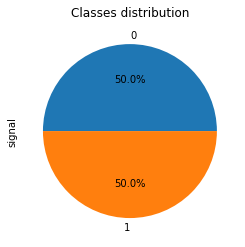

In [1263]:
print('Classes balancing...')

print('Before:')
print(pd.DataFrame(Y).value_counts())

rs = RandomUnderSampler(sampling_strategy='all', random_state=42)
# rs = RandomOverSampler(sampling_strategy='all', random_state=42)
X_bal, Y_bal = rs.fit_resample(X_prep, Y)

print('After:')
print(pd.DataFrame(Y_bal).value_counts())

ax = Y_bal.value_counts().plot.pie(autopct='%.1f%%')
_ = ax.set_title("Classes distribution")

# X_train, X_test, Y_train, Y_test = X_train_bal, X_test_bal, Y_train_bal, Y_test_bal
# print(X_train_bal)

# uclasses = np.unique(Y_train.values)
# cw = compute_class_weight("balanced", uclasses, Y_train.values)
# weights = { c : cw[c] for c in uclasses }
# # weights = {-1:6, 0:1, 1:6}
# print('class_weights: ', weights)

### Split train/test subsets

In [1264]:
print('Preparing train/test subdatasets...')
X_train, X_test, Y_train, Y_test = train_test_split(X_bal, Y_bal, test_size=0.2, random_state=0, shuffle=True)
print('train_len=%d test_len=%d' % (len(X_train), len(X_test)))
# print(X_train.tail())
# print(X_test.head())

Preparing train/test subdatasets...
train_len=867 test_len=217


signal
0         447
1         420
dtype: int64


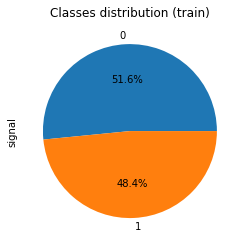

In [1265]:
bx = Y_train.value_counts().plot.pie(autopct='%.1f%%')
_ = bx.set_title("Classes distribution (train)")
print(pd.DataFrame(Y_train).value_counts())

signal
1         122
0          95
dtype: int64


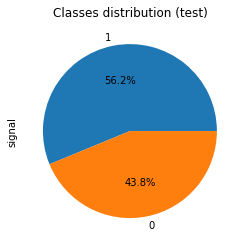

In [1266]:
cx = Y_test.value_counts().plot.pie(autopct='%.1f%%')
_ = cx.set_title("Classes distribution (test)")
print(pd.DataFrame(Y_test).value_counts())

## Model training

In [1267]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn import ensemble
from sklearn import model_selection
from sklearn import svm
from sklearn import neural_network

### RandomForest

In [1268]:
# print('Training with RandomForest...')
# rf_model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None,min_samples_leaf=1,min_samples_split=2,min_weight_fraction_leaf=0.0,n_estimators=1000,random_state=0,verbose=0,
# warm_start=False).fit(X_train,Y_train)

# print('Validating...')
# # cv_score = cross_val_score(rf_buy, X_test, Y_test, cv=gkcv).mean()
# print('Score (train): %.2f' % rf_model.score(X_train, Y_train))
# print('Score (test): %.2f' % rf_model.score(X_test, Y_test))

# Y_test_pred = rf_model.predict(X_test)
# kappa = cohen_kappa_score(Y_test_pred, Y_test)
# print('Kappa=%.2f' % kappa)

### SVC

In [1269]:
print('Training with SVC...')

model = svm.SVC(kernel='poly', degree=12)
# model = neural_network.BernoulliRBM(n_iter=1000)
# model = neural_network.MLPClassifier(hidden_layer_sizes=(800,800), max_iter=800)

# BEST
# model = svm.SVC(kernel='poly', degree=12)
# Score (train): 0.66
# Score (test): 0.65
# kappa=0.48

model.fit(X_train,Y_train)
print('Score (train): %.2f' % model.score(X_train, Y_train))
print('Score (test): %.2f' % model.score(X_test, Y_test))

Training with SVC...
Score (train): 0.82
Score (test): 0.81


In [1270]:
Y_test_pred = model.predict(X_test)

#use on classification
kappa = metrics.cohen_kappa_score(Y_test_pred, Y_test)
print('kappa=%.2f' % kappa)
f1 = metrics.f1_score(Y_test_pred, Y_test, average='weighted')
print('f1 score=%.2f' % f1)

# use on regression
# print("R2 score (test):", sklearn.metrics.r2_score(Y_test_bal, Y_test_pred_bal))

kappa=0.61
f1 score=0.81


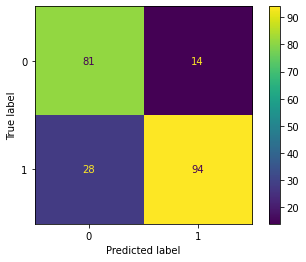

In [1271]:
# Y_test_pred = model.predict(X_test)
# cm = metrics.confusion_matrix(Y_test, Y_test_pred)
# print(cm)
metrics.plot_confusion_matrix(model, X_test, Y_test) 

In [1183]:
# print('Doing cross validation training...')
# cv_score = cross_val_score(model, X_train_bal, Y_train_bal, cv=5).mean()
# print("Cross validation score: %.2f" % cv_score)

### CNN with TensorFlow

#### Prepare data

In [1277]:
from keras.utils.np_utils import to_categorical

num_classes = 2

#one hot encoding
ty_bal_onehot = to_categorical(Y_bal)
# print(Y_bal_onehot)

# print(X_bal)
tx_bal = np.reshape(np.array(X_bal), (-1,input_columns,1))
# ty_bal_onehot2 = np.reshape(np.array(ty_bal_onehot), (-1,2,1))
# print(tx_bal)

#split train/test
tx_train, tx_test, ty_train, ty_test = train_test_split(tx_bal, ty_bal_onehot, test_size=0.2, random_state=0, shuffle=False)
print(tx_train.shape)
print(ty_train.shape)
# print(tx_train)

(867, 26, 1)
(867, 2)


#### Prepare model

In [1278]:
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import keras

model = Sequential()
model.add(Conv1D(512, kernel_size=(3),activation='linear',padding='same',input_shape=(input_columns,1)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling1D((3),padding='same'))
model.add(Dropout(0.25))
model.add(Conv1D(512, (6), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling1D(pool_size=(4),padding='same'))
model.add(Dropout(0.25))
model.add(Conv1D(512, (4), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(MaxPooling1D(pool_size=(3),padding='same'))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(256, activation='linear'))
model.add(LeakyReLU(alpha=0.1))           
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam',
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_62 (Conv1D)           (None, 26, 512)           2048      
_________________________________________________________________
leaky_re_lu_80 (LeakyReLU)   (None, 26, 512)           0         
_________________________________________________________________
max_pooling1d_60 (MaxPooling (None, 9, 512)            0         
_________________________________________________________________
dropout_80 (Dropout)         (None, 9, 512)            0         
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 9, 512)            1573376   
_________________________________________________________________
leaky_re_lu_81 (LeakyReLU)   (None, 9, 512)            0         
_________________________________________________________________
max_pooling1d_61 (MaxPooling (None, 3, 512)          

#### Train model

In [1279]:
print('Train model')
print(tx_train.shape)
print(ty_train.shape)
model.fit(tx_train, ty_train, epochs=5)

print('Test evaluation')
model.evaluate(tx_test, ty_test)

Train model
(867, 26, 1)
(867, 2)
Epoch 1/5
28/28 [==============================] - 8s 202ms/step - loss: 0.5693 - accuracy: 0.6909
Epoch 2/5
28/28 [==============================] - 6s 212ms/step - loss: 0.5227 - accuracy: 0.7647
Epoch 3/5
28/28 [==============================] - 6s 208ms/step - loss: 0.5281 - accuracy: 0.7705
Epoch 4/5
28/28 [==============================] - 5s 178ms/step - loss: 0.5077 - accuracy: 0.7820
Epoch 5/5
28/28 [==============================] - 6s 228ms/step - loss: 0.4880 - accuracy: 0.7889
Test evaluation
7/7 [==============================] - 0s 16ms/step - loss: 0.6591 - accuracy: 0.7143


[0.6591488718986511, 0.7142857313156128]

#### Evaluate model

In [1280]:
from sklearn.metrics import classification_report

ty_test_pred_onehot = model.predict(tx_test)
ty_test_pred_classes = np.argmax(np.round(ty_test_pred_onehot),axis=1)

# print(tx_test.shape)
# print(ty_test_pred_classes.shape)

ty_test_onehot = np.argmax(np.round(ty_test),axis=1)

# target_names = ["Class {}".format(i) for i in range(num_classes)]
# print(classification_report(ty_test_onehot, ty_test_pred_classes, target_names=target_names))

print(classification_report(ty_test_onehot, ty_test_pred_classes))

# ty_test_pred = model.predict(tx_test)
# # ty_pred_classes = argmax(ty_test_pred,axis=1)
# print(ty_test_classes)
# cm = metrics.confusion_matrix(tx_test, ty_test_classes)
# # print(ty_pred_classes.shape)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.71      0.83       217

    accuracy                           0.71       217
   macro avg       0.50      0.36      0.42       217
weighted avg       1.00      0.71      0.83       217



/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1281]:
ty_test_classes = np.argmax(ty_test,axis=1)

print('Confusion matrix:')
cm = metrics.confusion_matrix(ty_test_classes, ty_test_pred_classes)
print(cm)

Confusion matrix:
[[  0   0]
 [ 62 155]]


### AutoML trial

In [1282]:
import autosklearn.regression
import autosklearn.classification

# model = autosklearn.regression.AutoSklearnRegressor(
model = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=120,
    per_run_time_limit=30,
    tmp_folder='/tmp/autosklearn_regression_example_tmp',
    output_folder='/tmp/autosklearn_regression_example_out',
)

model.fit(X_train, Y_train)
print('Score (train): %.2f' % model.score(X_train, Y_train))
print('Score (test): %.2f' % model.score(X_test, Y_test))

Score (train): 0.99
Score (test): 0.95


In [686]:
# import sklearn
# # print(model.show_models())
# Y_test_pred = model.predict(X_test)
# print("R2 score over test samples:", sklearn.metrics.r2_score(Y_test, Y_test_pred))

## Validate model

In [1221]:
# import sklearn
# from sklearn.inspection import permutation_importance

### Confusion matrix

[[81 14]
 [28 94]]


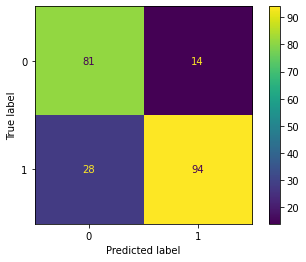

In [1276]:
Y_test_pred = model.predict(X_test)
cm = metrics.confusion_matrix(Y_test, Y_test_pred)
print(cm)
metrics.plot_confusion_matrix(model, X_test, Y_test) 

In [1272]:
Y_test_pred = model.predict(X_test)
# print(classification_report(Y_test, Y_test_pred, target_names=['sell','none','buy']))
print(metrics.classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

           0       0.74      0.85      0.79        95
           1       0.87      0.77      0.82       122

    accuracy                           0.81       217
   macro avg       0.81      0.81      0.81       217
weighted avg       0.81      0.81      0.81       217



### Feature importances

In [1273]:
print("Feature importances:")
features = zip(X.columns, model.feature_importances_)
features = sorted(features, key = lambda t: t[1], reverse=True)
for feat,imp in features:
    print('  - %s: %.2f' % (feat,imp))

Feature importances:


AttributeError: 'SVC' object has no attribute 'feature_importances_'

### Predict values

In [1274]:
df8 = df7.copy()

Y_pred = model.predict(X_prep)
df8['signal_predicted'] = Y_pred

### Show results on test subset

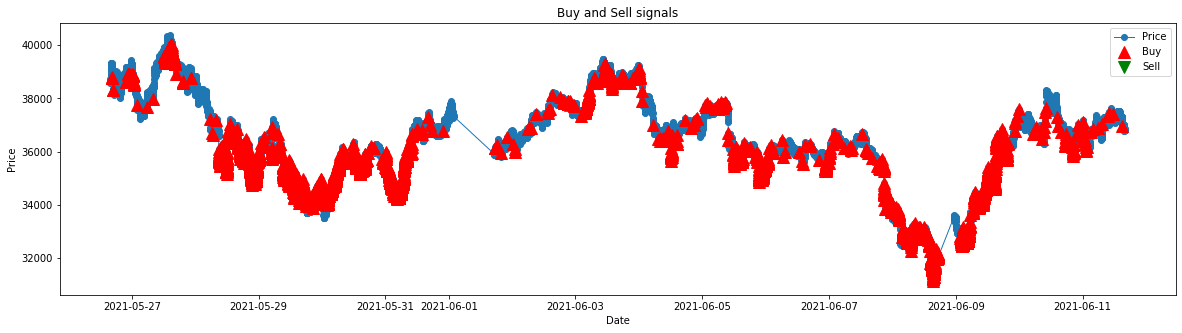

In [1275]:
df9 = df8.copy()

# df9 = df9[:len(X_train)]
# df9 = df9[len(X_train):]
# print(len(df9))
# df9 = df9[1000:2500]

fig = plt.figure(figsize=(20, 5))
buys = df9.loc[df9["signal_predicted"] == 1]
sells = df9.loc[df9["signal_predicted"] == 2]
plt.plot(df9.index, df9['close'], lw=1., marker='o', label='Price')
plt.plot(buys.index, df9.loc[buys.index]['close'], '^', markersize=12, color='red', lw=2., label='Buy')
plt.plot(sells.index, df9.loc[sells.index]['close'], 'v', markersize=12, color='green', lw=2., label='Sell')
# plt.vlines(X_test.index[0], ymin=np.min(df9['close'].values), ymax=np.max(df9['close'].values), colors='k', linestyles='dotted', label='<-train test->')
plt.ylabel('Price')
plt.xlabel('Date');
plt.title('Buy and Sell signals')
plt.legend(loc='best')
plt.show()

### Backtesting